# Extract profiles from SASSIE model at AXCTD coordinates

In [280]:
## Initalize Python libraries
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import s3fs
import ujson
from glob import glob
from pathlib import Path
import s3fs
import boto3
import dask
from dask.distributed import Client, LocalCluster
import pyresample
import cartopy
import cartopy.mpl.geoaxes
import cartopy.crs as ccrs
from tqdm.notebook import tqdm
import gsw

In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:34257")
client

<Client: 'tcp://127.0.0.1:34257' processes=8 threads=32, memory=123.94 GiB>

**Summary of available data:** <br>

First model granule: 2014-01-15<br>
Last model granule: 2021-02-07<br>

AXCTD: summers 2016-2021

Overlap between datasets is 2016-2020 (5 years)

## Load data

### AXCTD data

In [3]:
# this doesn't work even if file permissions are chmod 777
axctd_dir = Path('~/efs-mount-point/mzahn/melville/AXCTD_data/combined/')
print(list(axctd_dir.glob("*nc")))

[]


In [193]:
# open combined AXCTD dataset
axctd_dir = '~/efs-mount-point/mzahn/melville/AXCTD_data/combined/'
axctd_ds = xr.open_mfdataset([axctd_dir + "OMG_Ocean_AXCTD_Greenland_2016.nc",\
                              axctd_dir + "OMG_Ocean_AXCTD_Greenland_2017.nc",\
                              axctd_dir + "OMG_Ocean_AXCTD_Greenland_2018.nc",\
                              axctd_dir + "OMG_Ocean_AXCTD_Greenland_2019.nc",\
                              axctd_dir + "OMG_Ocean_AXCTD_Greenland_2020.nc"],\
                             combine='nested',concat_dim='profile')

In [197]:
# confirm that the merging of the datasets worked properly
tmp = xr.open_dataset(axctd_dir + "OMG_Ocean_AXCTD_Greenland_2019.nc")
print(tmp.isel(profile=200).time.values)
print(tmp.isel(profile=200).lat.values)
print(tmp.isel(profile=200).lon.values)

2019-09-04T13:16:39.000000000
74.11423
-56.46232


In [198]:
# make time a dimensional coordinate
axctd_ds_time = axctd_ds.swap_dims({"profile":"time"})

print(axctd_ds_time.sel(time='2019-09-04T13:16:39').lat.values)
print(axctd_ds_time.sel(time='2019-09-04T13:16:39').lon.values)

74.11423
-56.46232


Looks good

### SASSIE model data

Open geometry file

In [8]:
# First open geometry file for HH field
HH_grid = xr.open_dataset("~/efs-mount-point/mzahn/sassie/HH/GRID/GRID_GEOMETRY_SASSIE_HH_V1R1_NATIVE_LLC1080.nc")

Open `SALT` and `THETA` fields

In [9]:
def get_aws_credentials(profile_name='sassie'):
    session = boto3.Session(profile_name=profile_name)
    credentials = session.get_credentials()

    return credentials

In [10]:
# load sassie profile credentials
aws_credentials = get_aws_credentials(profile_name='sassie')

In [11]:
# initialize s3 filesystem
s3_options = dict(anon=False, key=aws_credentials.access_key, secret=aws_credentials.secret_key)

In [12]:
# function to open zarr store with a provided s3 bucket path
def open_zarr_store(s3_path, s3_options):
    # initalize s3 file system
    s3 = s3fs.S3FileSystem(**s3_options)

    # define location of zarr store and open
    store = s3fs.S3Map(root=s3_path, s3=s3, check=False)
    zarr_store = xr.open_zarr(store)
    
    return zarr_store

In [13]:
# open THETA zarr store
theta_zarr = open_zarr_store('s3://podaac-dev-sassie/ECCO_model/N1/V1R1/HH/ZARR/THETA_AVG_DAILY.ZARR/', s3_options)

# open SALT zarr store
salt_zarr = open_zarr_store('s3://podaac-dev-sassie/ECCO_model/N1/V1R1/HH/ZARR/SALT_AVG_DAILY.ZARR/', s3_options)

## Extract profiles from model

In [199]:
bathy_melville = HH_grid.Depth.isel(i=slice(1190,1310),j=slice(45,150)).compute()
bathy_melville_wet = bathy_melville.where(bathy_melville!=0)

In [200]:
indexer = (np.logical_and(axctd_ds.lat>73,axctd_ds.lat<77)).compute()
axctd_melville_ds = axctd_ds.where(indexer,drop=True)
indexer = (np.logical_and(axctd_melville_ds.lon>-68,axctd_melville_ds.lon<-57)).compute()
axctd_melville_ds = axctd_melville_ds.where(indexer,drop=True)

Look at AXCTD locations overlaid on model bathymetry

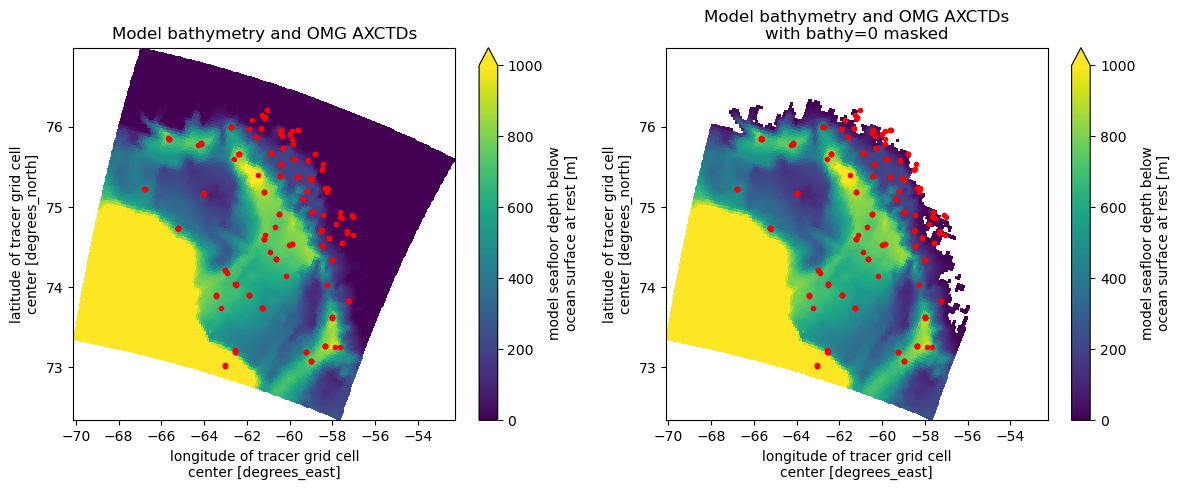

In [201]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=[12,5])

# HH_grid.Depth.isel(i=slice(1200,1300),j=slice(25,150)).plot(ax=ax1,y='YC',x='XC',vmin=0,vmax=1000);
bathy_melville.plot(ax=ax1,y='YC',x='XC',vmin=0,vmax=1000);
ax1.plot(axctd_melville_ds.lon, axctd_melville_ds.lat,'ro',markersize=3)
ax1.set_title("Model bathymetry and OMG AXCTDs")

bathy_melville_wet.plot(ax=ax2,y='YC',x='XC',vmin=0,vmax=1000);
ax2.plot(axctd_melville_ds.lon, axctd_melville_ds.lat,'ro',markersize=3)
ax2.set_title("Model bathymetry and OMG AXCTDs\nwith bathy=0 masked")

plt.tight_layout()

In [207]:
def extract_model_profiles(axctd_ds, model_ds):
    """
    Extracts vertical profiles from SASSIE model dataset using lat-lon coordinates from AXCTD profiles
    Returns dataset of concatenates profiles from model with same indices of corresponding AXCTD profiles
    """
    # add coordinates for profile number that will match between axctd and model profiles
    # axctd_ds = axctd_ds.assign_coords({"axctd_profile":("time",range(len(axctd_ds.time.values)))})

    # loop through all axctd profiles and extract matching model profile
    for i in tqdm(range(len(axctd_ds.profile))):
        profile = axctd_ds.isel(profile=i)
        # print(f'. . . processing profile {i} collected at {profile.time.values}')
        
        # extract model data for day of AXCTD profile
        model_day = model_ds.sel(time=profile.time.values, method='nearest')
    
        # Find the indices of the closest latitude and longitude
        distance = np.sqrt((model_day.YC - profile.lat.values)**2 + (model_day.XC - profile.lon.values)**2)
        min_dist_index = distance.argmin(dim=['j', 'i']) # returns a dictionary
        
        # Get the i, j indices of the closest point
        i_idx = min_dist_index['i']
        j_idx = min_dist_index['j']
    
        # Use the indices to select the time series at the closest point
        model_prof = model_day.sel(i=i_idx.values, j=j_idx.values)
    
        # append profile to dataset
        if i==0:
            model_profiles = model_prof.expand_dims("model_profile")
        else:
            model_prof_tmp = model_prof.expand_dims("model_profile")
            model_profiles = xr.concat([model_profiles, model_prof_tmp],dim="model_profile")

    # return both datasets
    return model_profiles

In [227]:
model_theta_profiles = extract_model_profiles(axctd_melville_ds, theta_zarr)
model_salt_profiles = extract_model_profiles(axctd_melville_ds, salt_zarr)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 223/223 [02:13<00:00,  1.68it/s]


In [211]:
# check to make sure indexing matches
model_tmp = model_theta_profiles.isel(model_profile=10)
ctd_tmp = axctd_melville_ds.isel(profile=10)

print(f'model time: {model_tmp.time.values}\nmodel lat: {model_tmp.YC.values}\nmodel_lon: {model_tmp.XC.values}')
print(f'\nAXCTD time: {ctd_tmp.time.values}\nAXCTD lat: {ctd_tmp.lat.values}\nAXCTD lon: {ctd_tmp.lon.values}')

model time: 2016-09-24T12:00:00.000000000
model lat: 73.24820709228516
model_lon: -58.36795425415039

AXCTD time: 2016-09-24T18:18:02.000000000
AXCTD lat: 73.26609802246094
AXCTD lon: -58.361351013183594


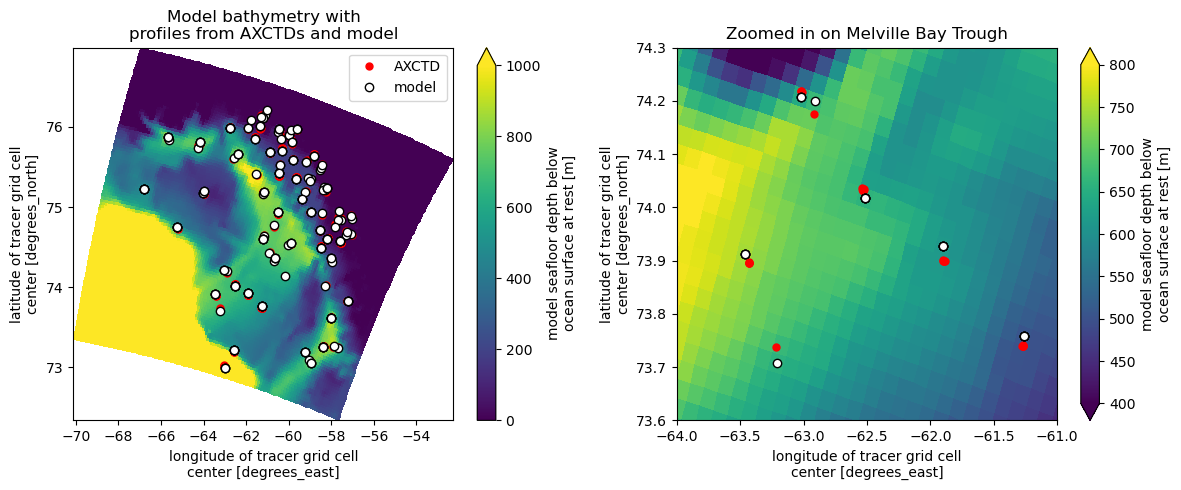

In [225]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=[12,5])

# HH_grid.Depth.isel(i=slice(1200,1300),j=slice(25,150)).plot(ax=ax1,y='YC',x='XC',vmin=0,vmax=1000);
bathy_melville.plot(ax=ax1,y='YC',x='XC',vmin=0,vmax=1000);
ax1.plot(lon_tmp,lat_tmp,'ro');
ax1.plot(axctd_melville_ds.lon, axctd_melville_ds.lat,'ro',markersize=5,label='AXCTD')
ax1.plot(model_theta_profiles.XC.values,model_theta_profiles.YC.values,'wo',markersize=6,markeredgecolor='k',label='model');
ax1.legend()

bathy_melville.plot(ax=ax2,y='YC',x='XC',vmin=400,vmax=800);
ax2.plot(lon_tmp,lat_tmp,'ro');
ax2.plot(axctd_melville_ds.lon, axctd_melville_ds.lat,'ro',markersize=5)
ax2.plot(model_theta_profiles.XC.values,model_theta_profiles.YC.values,'wo',markersize=6,markeredgecolor='k');
ax2.set_ylim(73.6,74.3)
ax2.set_xlim(-64,-61)

ax1.set_title("Model bathymetry with\nprofiles from AXCTDs and model")
ax2.set_title("Zoomed in on Melville Bay Trough")

plt.tight_layout()

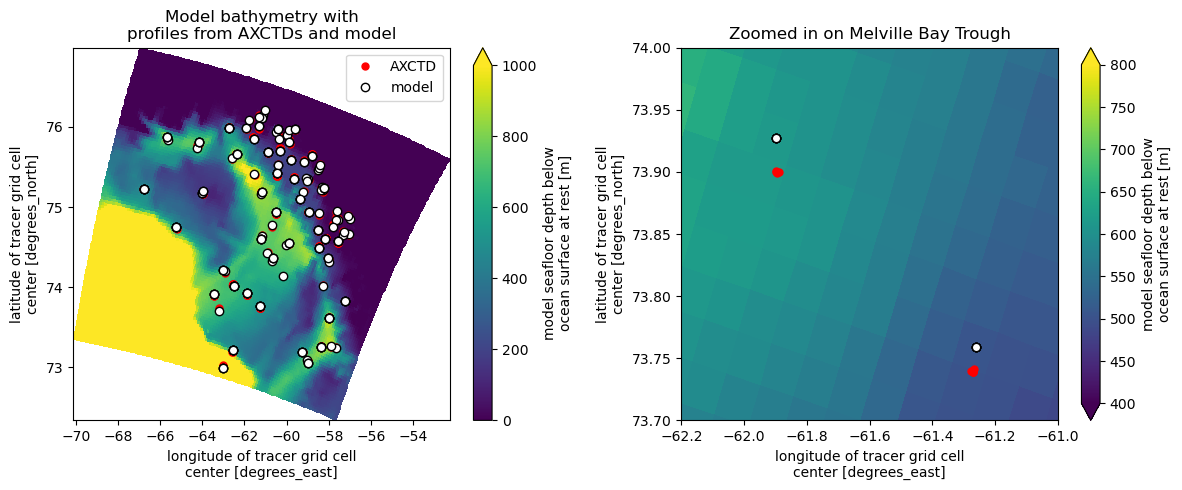

In [226]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=[12,5])

# HH_grid.Depth.isel(i=slice(1200,1300),j=slice(25,150)).plot(ax=ax1,y='YC',x='XC',vmin=0,vmax=1000);
bathy_melville.plot(ax=ax1,y='YC',x='XC',vmin=0,vmax=1000);
ax1.plot(lon_tmp,lat_tmp,'ro');
ax1.plot(axctd_melville_ds.lon, axctd_melville_ds.lat,'ro',markersize=5,label='AXCTD')
ax1.plot(model_theta_profiles.XC.values,model_theta_profiles.YC.values,'wo',markersize=6,markeredgecolor='k',label='model');
ax1.legend()

bathy_melville.plot(ax=ax2,y='YC',x='XC',vmin=400,vmax=800);
ax2.plot(lon_tmp,lat_tmp,'ro');
ax2.plot(axctd_melville_ds.lon, axctd_melville_ds.lat,'ro',markersize=5)
ax2.plot(model_theta_profiles.XC.values,model_theta_profiles.YC.values,'wo',markersize=6,markeredgecolor='k');
ax2.set_ylim(73.7,74)
ax2.set_xlim(-62.2,-61)

ax1.set_title("Model bathymetry with\nprofiles from AXCTDs and model")
ax2.set_title("Zoomed in on Melville Bay Trough")

plt.tight_layout()

## Project model profiles onto AXCTD depth coordinate

In [256]:
# make Z a dimensional coord
model_theta_profiles_z = model_theta_profiles.swap_dims({'k':'Z'})
model_salt_profiles_z = model_salt_profiles.swap_dims({'k':'Z'})

In [262]:
# make depth negative down to match model
axctd_melville_ds['depth'] = axctd_melville_ds.depth.values*(-1)

In [263]:
# interpolate model profile along AXCTD depth coord

# temperature
model_theta_profiles_interp = model_theta_profiles_z.interp(Z=axctd_melville_ds.depth.values).compute()
#salinity
model_salt_profiles_interp = model_salt_profiles_z.interp(Z=axctd_melville_ds.depth.values).compute()

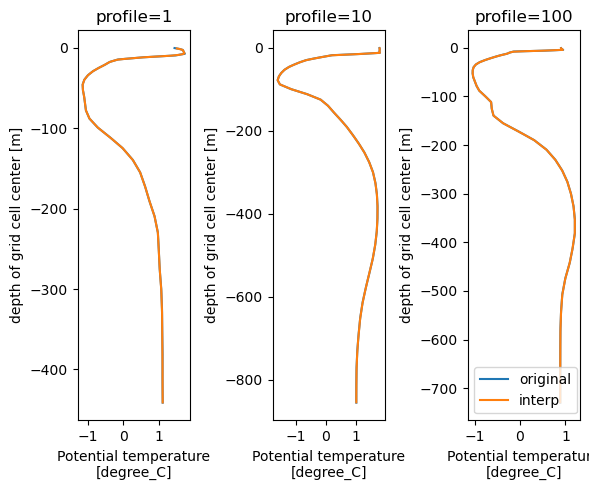

In [265]:
# compare a few
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=[6,5])

model_theta_profiles.THETA.isel(model_profile=1).plot(ax=ax1,y='Z')
model_theta_profiles_interp.THETA.isel(model_profile=1).plot(ax=ax1,y='Z')
ax1.set_title("profile=1")
model_theta_profiles.THETA.isel(model_profile=10).plot(ax=ax2,y='Z')
model_theta_profiles_interp.THETA.isel(model_profile=10).plot(ax=ax2,y='Z')
ax2.set_title("profile=10")
model_theta_profiles.THETA.isel(model_profile=100).plot(ax=ax3,y='Z',label='original')
model_theta_profiles_interp.THETA.isel(model_profile=100).plot(ax=ax3,y='Z',label='interp')
ax3.set_title("profile=100")
ax3.legend(loc='lower left')
plt.tight_layout()

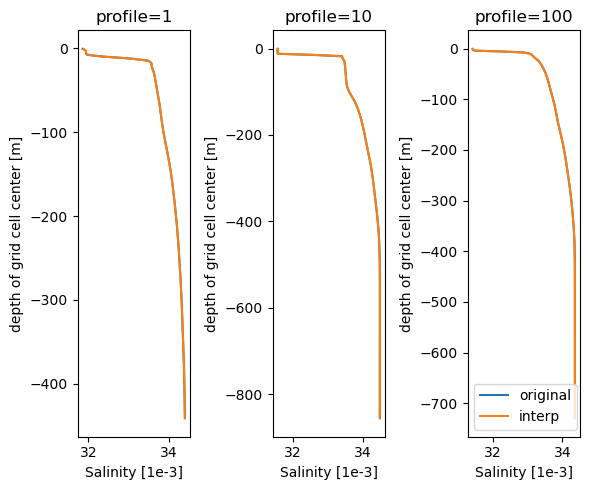

In [266]:
# compare a few
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=[6,5])

model_salt_profiles.SALT.isel(model_profile=1).plot(ax=ax1,y='Z')
model_salt_profiles_interp.SALT.isel(model_profile=1).plot(ax=ax1,y='Z')
ax1.set_title("profile=1")
model_salt_profiles.SALT.isel(model_profile=10).plot(ax=ax2,y='Z')
model_salt_profiles_interp.SALT.isel(model_profile=10).plot(ax=ax2,y='Z')
ax2.set_title("profile=10")
model_salt_profiles.SALT.isel(model_profile=100).plot(ax=ax3,y='Z',label='original')
model_salt_profiles_interp.SALT.isel(model_profile=100).plot(ax=ax3,y='Z',label='interp')
ax3.set_title("profile=100")
ax3.legend(loc='lower left')
plt.tight_layout()

## Convert to TEOS-10 standards

### Pressure from Z

In [301]:
# change 'depth' to 'Z' to match model
axctd_melville_ds = axctd_melville_ds.rename({"depth":"Z"})

In [315]:
pressure_da = gsw.conversions.p_from_z(axctd_melville_ds.Z,\
                                       axctd_melville_ds.lat.mean().values,\
                                       geo_strf_dyn_height=0, sea_surface_geopotential=0)

### Absolute Salinity

In [322]:
# Calculates Absolute Salinity from Practical Salinity. 
# Since SP is non-negative by definition, this function changes any negative input values of SP to be zero.

# AXCTD
axctd_melville_SA_ds = gsw.conversions.SA_from_SP(axctd_melville_ds.salinity, pressure_da,\
                                                  axctd_melville_ds.lon, axctd_melville_ds.lat)
# model
model_SA_profiles_interp = gsw.conversions.SA_from_SP(model_salt_profiles_interp.SALT, pressure_da,\
                                                      model_salt_profiles_interp.XC, model_salt_profiles_interp.YC)

In [323]:
# add this new variable to the original dataset
axctd_melville_ds['absolute_salinity'] = axctd_melville_SA_ds
model_salt_profiles_interp['absolute_salinity'] = model_SA_profiles_interp

### Conservative Temperature

In [324]:
# AXCTD
# Calculates Conservative Temperature of seawater from in-situ temperature.
axctd_melville_CT_ds = gsw.conversions.CT_from_t(axctd_melville_SA_ds, axctd_melville_ds.temperature, pressure_da)

# model
# Calculates Conservative Temperature of seawater from potential temperature (whose reference sea pressure is zero dbar).
model_CT_profiles_interp = gsw.conversions.CT_from_pt(model_SA_profiles_interp, model_theta_profiles_interp.THETA)

In [325]:
# add this new variable to the original dataset
axctd_melville_ds['conservative_temperature'] = axctd_melville_CT_ds
model_theta_profiles_interp['conservative_temperature'] = model_CT_profiles_interp

### Potential Density

In [340]:
# calculate potential density
axctd_melville_rho_ds = gsw.density.sigma0(axctd_melville_SA_ds, axctd_melville_CT_ds)

In [342]:
axctd_melville_ds['potential_density'] = axctd_melville_rho_ds

In [327]:
# calculate potential density
model_rho_profiles_interp = gsw.density.sigma0(model_SA_profiles_interp, model_CT_profiles_interp)

In [328]:
model_rho_profiles_interp.name = 'potential_density'

### Merge model datasets into one

In [332]:
model_melville_ds = xr.merge([model_theta_profiles_interp, model_salt_profiles_interp, model_rho_profiles_interp])

## Plot corresponding AXCTD and model profiles

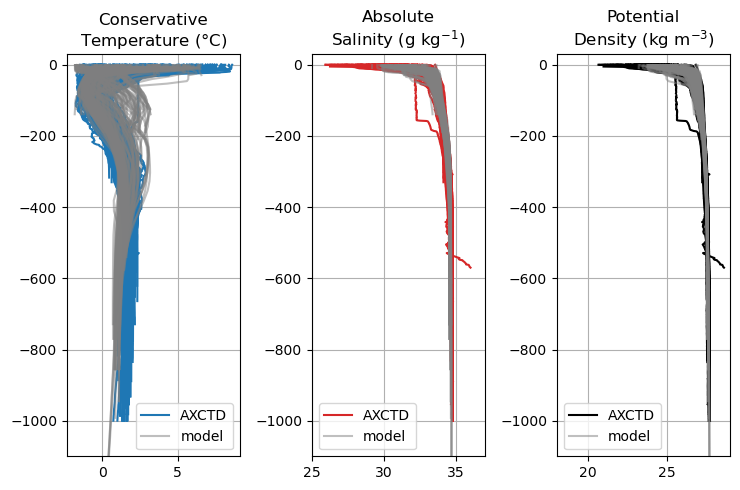

In [348]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=[7.5,5])

for i in range(len(axctd_melville_ds.profile)):
    ax1.plot(axctd_melville_ds.isel(profile=i).conservative_temperature,axctd_melville_ds.Z,c='tab:blue')
ax1.plot(axctd_melville_ds.isel(profile=-1).conservative_temperature,axctd_melville_ds.Z,label='AXCTD',c='tab:blue') # for legend

for i in range(len(model_melville_ds.model_profile)):
    ax1.plot(model_melville_ds.conservative_temperature.isel(model_profile=i).values,model_melville_ds.Z.values,c='tab:gray',alpha=0.5);
ax1.plot(model_melville_ds.conservative_temperature.isel(model_profile=-1).values,model_melville_ds.Z.values,label='model',c='tab:gray',alpha=0.5); # for legend

for i in range(len(axctd_melville_ds.profile)):
    ax2.plot(axctd_melville_ds.isel(profile=i).absolute_salinity,axctd_melville_ds.Z,c='tab:red')
ax2.plot(axctd_melville_ds.isel(profile=-1).absolute_salinity,axctd_melville_ds.Z,label='AXCTD',c='tab:red')
for i in range(len(model_melville_ds.model_profile)):
    ax2.plot(model_melville_ds.absolute_salinity.isel(model_profile=i).values,model_melville_ds.Z.values,c='gray',alpha=0.5);
ax2.plot(model_melville_ds.absolute_salinity.isel(model_profile=-1).values,model_melville_ds.Z.values,label='model',c='gray',alpha=0.5);

for i in range(len(axctd_melville_ds.profile)):
    ax3.plot(axctd_melville_ds.isel(profile=i).potential_density,axctd_melville_ds.Z,c='k')
ax3.plot(axctd_melville_ds.isel(profile=-1).potential_density,axctd_melville_ds.Z,label='AXCTD',c='k')
for i in range(len(model_melville_ds.model_profile)):
    ax3.plot(model_melville_ds.potential_density.isel(model_profile=i).values,model_melville_ds.Z.values,c='gray',alpha=0.5);
ax3.plot(model_melville_ds.potential_density.isel(model_profile=-1).values,model_melville_ds.Z.values,label='model',c='gray',alpha=0.5);

for ax in (ax1,ax2,ax3):
    ax.legend()
    ax.set_ylim(-1100,30);
    ax.grid()

ax2.set_xlim(25,37);
ax3.set_xlim(18,29);

ax1.set_title("Conservative\nTemperature ($\degree$C)")
ax2.set_title("Absolute\nSalinity (g kg$^{-1}$)");
ax3.set_title("Potential\nDensity (kg m$^{-3}$)");

plt.tight_layout();

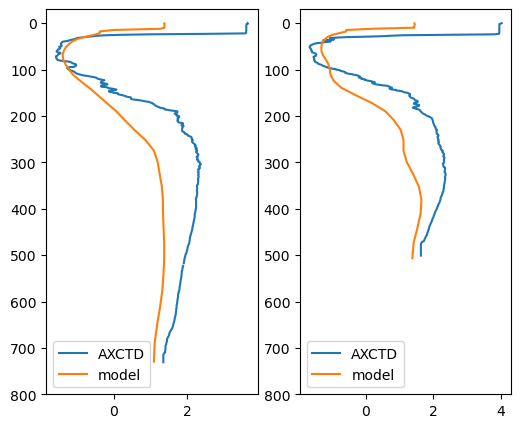

In [469]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=[6,5])

ax1.plot(axctd_melville_ds.isel(time=3).conservative_temperature,axctd_melville_ds.isel(time=3).depth,label='AXCTD')
ax1.plot(model_theta_profiles.THETA.values,theta_profile_z.Z.values,label='model');
ax1.legend()
ax1.set_ylim(800,-30);

ax2.plot(axctd_melville_ds.isel(time=6).conservative_temperature,axctd_melville_ds.isel(time=6).depth,label='AXCTD')
ax2.plot(theta_profile_z1.values,theta_profile_z1.Z.values,label='model');
ax2.legend()
ax2.set_ylim(800,-30);

Look at anomalies between years and between inshore/offshore